In [78]:
import torch
import torchvision
import os
import glob
import time 
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

In [79]:
class LungDataset(torch.utils.data.Dataset):
    def __init__(self, origin_mask_list, origins_folder, masks_folder, transforms=None):
        self.origin_mask_list = origin_mask_list
        self.origins_folder = origins_folder
        self.masks_folder = masks_folder
        self.transforms = transforms
    
    def __getitem__(self, idx):
        origin_name, mask_name = self.origin_mask_list[idx]
        origin = Image.open(self.origins_folder / (origin_name + ".png")).convert("P")
        mask = Image.open(self.masks_folder / (mask_name + ".png"))
        if self.transforms is not None:
            origin, mask = self.transforms((origin, mask))
            
        origin = torchvision.transforms.functional.to_tensor(origin) - 0.5
    
        mask = np.array(mask)
        mask = (torch.tensor(mask) > 128).long() 
        return origin, mask
        
    
    def __len__(self):
        return len(self.origin_mask_list)
class Pad():
    def __init__(self, max_padding):
        self.max_padding = max_padding
        
    def __call__(self, sample):
        origin, mask = sample
        padding = np.random.randint(0, self.max_padding)
        #origin = torchvision.transforms.functional.pad(origin, padding=padding, padding_mode="symmetric")
        origin = torchvision.transforms.functional.pad(origin, padding=padding, fill=0)
        mask = torchvision.transforms.functional.pad(mask, padding=padding, fill=0)
        return origin, mask
class Crop():
    def __init__(self, max_shift):
        self.max_shift = max_shift
        
    def __call__(self, sample):
        origin, mask = sample
        tl_shift = np.random.randint(0, self.max_shift)
        br_shift = np.random.randint(0, self.max_shift)
        origin_w, origin_h = origin.size
        crop_w = origin_w - tl_shift - br_shift
        crop_h = origin_h - tl_shift - br_shift
        
        origin = torchvision.transforms.functional.crop(origin, tl_shift, tl_shift,
                                                        crop_h, crop_w)
        mask = torchvision.transforms.functional.crop(mask, tl_shift, tl_shift,
                                                        crop_h, crop_w)
        return origin, mask
class Resize():
    def __init__(self, output_size):
        self.output_size = output_size
        
    def __call__(self, sample):
        origin, mask = sample
        origin = torchvision.transforms.functional.resize(origin, self.output_size)
        mask = torchvision.transforms.functional.resize(mask, self.output_size)
        
        return origin, mask

In [80]:
def blend(origin, out):
    '''crop the predicted output with black background'''
    origin=torchvision.transforms.functional.to_pil_image(origin+0.5)
    out=torchvision.transforms.functional.to_pil_image(out+0.0)
    origin_pixel=list(origin.getdata())
    out_pixel=list(out.getdata())
    for i in range(len(out_pixel)):
        if out_pixel[i]==0:
            origin_pixel[i]=0
    origin.putdata(origin_pixel)
    origin=origin.convert("RGB")
    return origin

In [81]:
def jaccard(y_true, y_pred):
    """ Jaccard IoU score for batch of images
    """
    
    num = y_true.size(0)
    eps = 1e-7
    
    y_true_flat = y_true.view(num, -1)
    y_pred_flat = y_pred.view(num, -1)
    intersection = (y_true_flat * y_pred_flat).sum(1)
    union = ((y_true_flat + y_pred_flat) > 0.0).float().sum(1)
    
    score = (intersection) / (union + eps)
    score = score.sum() / num
    return score

In [82]:
def dice(y_true, y_pred):
    """ Dice f1 score for batch of images
    """
    num = y_true.size(0)
    eps = 1e-7
    
    y_true_flat = y_true.view(num, -1)
    y_pred_flat = y_pred.view(num, -1)
    intersection = (y_true_flat * y_pred_flat).sum(1)
    
    score =  (2 * intersection) / (y_true_flat.sum(1) + y_pred_flat.sum(1) + eps)
    score = score.sum() / num
    return score

In [83]:
class Block(torch.nn.Module):
    def __init__(self, in_channels, mid_channel, out_channels, batch_norm=False):
        super().__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=mid_channel, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, padding=1)
        
        self.batch_norm = batch_norm
        if batch_norm:
            self.bn1 = torch.nn.BatchNorm2d(mid_channel)
            self.bn2 = torch.nn.BatchNorm2d(out_channels)
            
    def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = torch.nn.functional.relu(x, inplace=True)
        
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        out = torch.nn.functional.relu(x, inplace=True)
        return out
    
class UNet(torch.nn.Module):
    def up(self, x, size):
        return torch.nn.functional.interpolate(x, size=size, mode=self.upscale_mode)
    
    def down(self, x):
        return torch.nn.functional.max_pool2d(x, kernel_size=2)
    
    def __init__(self, in_channels, out_channels, batch_norm=False, upscale_mode="nearest"):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_norm = batch_norm
        self.upscale_mode = upscale_mode
        
        self.enc1 = Block(in_channels, 64, 64, batch_norm)
        self.enc2 = Block(64, 128, 128, batch_norm)
        self.enc3 = Block(128, 256, 256, batch_norm)
        self.enc4 = Block(256, 512, 512, batch_norm)
        
        self.center = Block(512, 1024, 512, batch_norm)
        
        self.dec4 = Block(1024, 512, 256, batch_norm)
        self.dec3 = Block(512, 256, 128, batch_norm)
        self.dec2 = Block(256, 128, 64, batch_norm)
        self.dec1 = Block(128, 64, 64, batch_norm)
        
        self.out = torch.nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.down(enc1))
        enc3 = self.enc3(self.down(enc2))
        enc4 = self.enc4(self.down(enc3))
        
        center = self.center(self.down(enc4))
        
        dec4 = self.dec4(torch.cat([self.up(center, enc4.size()[-2:]), enc4], 1))
        dec3 = self.dec3(torch.cat([self.up(dec4, enc3.size()[-2:]), enc3], 1))
        dec2 = self.dec2(torch.cat([self.up(dec3, enc2.size()[-2:]), enc2], 1))
        dec1 = self.dec1(torch.cat([self.up(dec2, enc1.size()[-2:]), enc1], 1))
        
        out = self.out(dec1)
        
        return out

In [84]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# data preparation phase

In [85]:
#path of the images and masks
data_folder = Path("datasets","dataset")
origins_folder = data_folder / "images"
masks_folder = data_folder / "masks"

In [86]:
batch_size = 2

In [87]:
origins_list = [f.stem for f in origins_folder.glob("*.png")]
masks_list = [f.stem for f in masks_folder.glob("*.png")]

In [88]:
#few mask images name have "_mask" appended. It is been removed to make the image name and mask name same
origin_mask_list = [(mask_name.replace("_mask", ""), mask_name) for mask_name in masks_list]

In [89]:
print(len(origins_list))
print(len(masks_list))

800
704


In [90]:
#training validation and test data split
splits = {}
splits["train"], splits["test"] = train_test_split(origin_mask_list, test_size=0.2, random_state=42)
splits["train"], splits["val"] = train_test_split(splits["train"], test_size=0.1, random_state=42)

In [91]:
val_test_transforms = torchvision.transforms.Compose([
    Resize((256,256)),
])

train_transforms = torchvision.transforms.Compose([
    Pad(200),
    Crop(300),
    val_test_transforms,
])

datasets = {x: LungDataset(
    splits[x], 
    origins_folder, 
    masks_folder, 
    train_transforms if x == "train" else val_test_transforms
) for x in ["train", "test", "val"]}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size) for x in ["train", "test", "val"]}

# Training phase

In [92]:
unet = UNet(
    in_channels=1,
    out_channels=2, 
    batch_norm=True, 
    upscale_mode="bilinear"
)
unet

UNet(
  (enc1): Block(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enc2): Block(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enc3): Block(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [93]:
unet = unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=0.0005)

In [94]:
train_log_filename = "train-log.txt"
epochs = 20
best_val_loss = np.inf
model_name = "webapp/saved_models/unet_model.pt"

In [18]:
#training
hist = []

for e in range(epochs):
    start_t = time.time()
    
    print("train phase")
    unet.train()
    train_loss = 0.0
    for origins, masks in dataloaders["train"]:
        num = origins.size(0)
        
        origins = origins.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        outs = unet(origins)
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        loss = torch.nn.functional.nll_loss(softmax, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * num
        print(".", end="")
        
    train_loss = train_loss / len(datasets['train'])
    print()
    
    
    print("validation phase")
    unet.eval()
    val_loss = 0.0
    val_jaccard = 0.0
    val_dice = 0.0

    for origins, masks in dataloaders["val"]:
        num = origins.size(0)

        origins = origins.to(device)
        masks = masks.to(device)

        with torch.no_grad():
            outs = unet(origins)
            softmax = torch.nn.functional.log_softmax(outs, dim=1)
            val_loss += torch.nn.functional.nll_loss(softmax, masks).item() * num

            outs = torch.argmax(softmax, dim=1)
            outs = outs.float()
            masks = masks.float()
            val_jaccard += jaccard(masks, outs.float()).item() * num
            val_dice += dice(masks, outs).item() * num

        print(".", end="")
    val_loss = val_loss / len(datasets["val"])
    val_jaccard = val_jaccard / len(datasets["val"])
    val_dice = val_dice / len(datasets["val"])
    print()
    
    
    end_t = time.time()
    spended_t = end_t - start_t
    
    with open(train_log_filename, "a") as train_log_file:
        report = f"epoch: {e+1}/{epochs}, time: {spended_t}, train loss: {train_loss}, \n"\
               + f"val loss: {val_loss}, val jaccard: {val_jaccard}, val dice: {val_dice}"

        hist.append({
            "time": spended_t,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_jaccard": val_jaccard,
            "val_dice": val_dice,
        })

        print(report)
        train_log_file.write(report + "\n")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(unet.state_dict(),model_name)
            print("model saved")
            train_log_file.write("model saved\n")
        print()

train phase


/home/reddirouthuradhika@gmail.com/anaconda3/envs/project-xray/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


.............................................................................................................................................................................................................................................................
validation phase
.............................
epoch: 1/20, time: 443.5993084907532, train loss: 0.2738238858729012, 
val loss: 0.1776634331857949, val jaccard: 0.7881066558653849, val dice: 0.8800254150440818
model saved

train phase
.............................................................................................................................................................................................................................................................
validation phase
.............................
epoch: 2/20, time: 444.3151819705963, train loss: 0.15858944140286313, 
val loss: 0.13580826356222755, val jaccard: 0.8073325606814602, val dice: 0.8891385155811644
model saved

train phase
....................

epochs: 20, overall time: 149.0m, mean epoch time: 449.9785623431206s


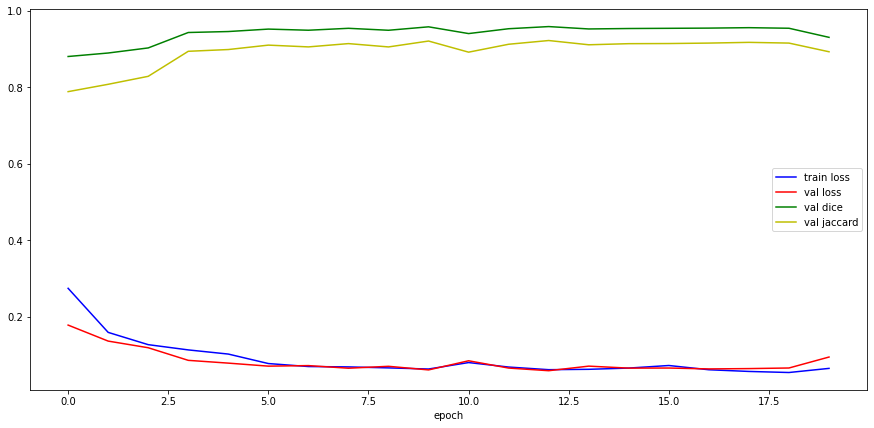

In [20]:
#plotting train loss, val loss, val dice, val jaccard
plt.figure(figsize=(15,7))
train_loss_hist = [h["train_loss"] for h in hist]
plt.plot(range(len(hist)), train_loss_hist, "b", label="train loss")

val_loss_hist = [h["val_loss"] for h in hist]
plt.plot(range(len(hist)), val_loss_hist, "r", label="val loss")

val_dice_hist = [h["val_dice"] for h in hist]
plt.plot(range(len(hist)), val_dice_hist, "g", label="val dice")

val_jaccard_hist = [h["val_jaccard"] for h in hist]
plt.plot(range(len(hist)), val_jaccard_hist, "y", label="val jaccard")

plt.legend()
plt.xlabel("epoch")
plt.savefig(model_name.replace(".pt", "-train-hist.png"))

time_hist = [h["time"] for h in hist]
overall_time = sum(time_hist) // 60
mean_epoch_time = sum(time_hist) / len(hist)
print(f"epochs: {len(hist)}, overall time: {overall_time}m, mean epoch time: {mean_epoch_time}s")

In [ ]:
torch.cuda.empty_cache()

# Testing phase

In [95]:
#loading the model
unet = UNet(1, 2, True, "bilinear")

In [96]:
model_name = "webapp/saved_models//unet_model.pt" #give the path of the saved model
unet.load_state_dict(torch.load(model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

In [97]:
test_loss = 0.0
test_jaccard = 0.0
test_dice = 0.0

for origins, masks in dataloaders["test"]:
    num = origins.size(0)

    origins = origins.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        outs = unet(origins)
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        test_loss += torch.nn.functional.nll_loss(softmax, masks).item() * num

        outs = torch.argmax(softmax, dim=1)
        outs = outs.float()
        masks = masks.float()
        test_jaccard += jaccard(masks, outs).item() * num
        test_dice += dice(masks, outs).item() * num
    print(".", end="")

test_loss = test_loss / len(datasets["test"])
test_jaccard = test_jaccard / len(datasets["test"])
test_dice = test_dice / len(datasets["test"])

print()
print(f"avg test loss: {test_loss}")
print(f"avg test jaccard: {test_jaccard}")
print(f"avg test dice: {test_dice}")

.......................................................................
avg test loss: 0.057260130578321765
avg test jaccard: 0.9202538661077513
avg test dice: 0.9573033143442573


...


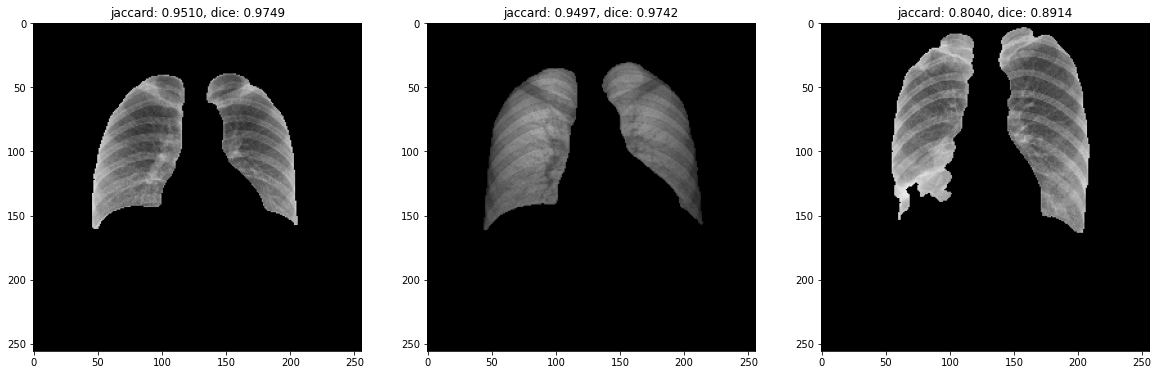

In [98]:
num_samples = 3
phase = "test"

subset = torch.utils.data.Subset(
    datasets[phase], 
    np.random.randint(0, len(datasets[phase]), num_samples)
)
random_samples_loader = torch.utils.data.DataLoader(subset, batch_size=1)
plt.figure(figsize=(20, 25))

for idx, (origin, mask) in enumerate(random_samples_loader):
    plt.subplot((num_samples // 3) + 1, 3, idx+1)

    origin = origin.to(device)
    mask = mask.to(device)

    with torch.no_grad():
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)

        jaccard_score = jaccard(mask.float(), out.float()).item()
        dice_score = dice(mask.float(), out.float()).item()

        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        mask = mask[0].to("cpu")

        plt.imshow(np.array(blend(origin,out)))
        plt.title(f"jaccard: {jaccard_score:.4f}, dice: {dice_score:.4f}")
        print(".", end="")
            
plt.savefig("obtained-results.png", bbox_inches='tight')
print()   

# Prediction (user input)

In [99]:
unet = UNet(
    in_channels=1,
    out_channels=2, 
    batch_norm=True, 
    upscale_mode="bilinear"
)

In [100]:
model_name = "webapp/saved_models/unet_model.pt" #give the path of the saved model
unet.load_state_dict(torch.load(model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

In [101]:
#give path of the image
origin_filename = "images/lung_xray.png"

In [102]:
origin = Image.open(origin_filename).convert("P")
origin = torchvision.transforms.functional.resize(origin, (512, 512))
origin = torchvision.transforms.functional.to_tensor(origin) - 0.5
with torch.no_grad():
    origin = torch.stack([origin])
    origin = origin.to(device)
    out = unet(origin)
    softmax = torch.nn.functional.log_softmax(out, dim=1)
    out = torch.argmax(softmax, dim=1)
    
    origin = origin[0].to("cpu")
    out = out[0].to("cpu")

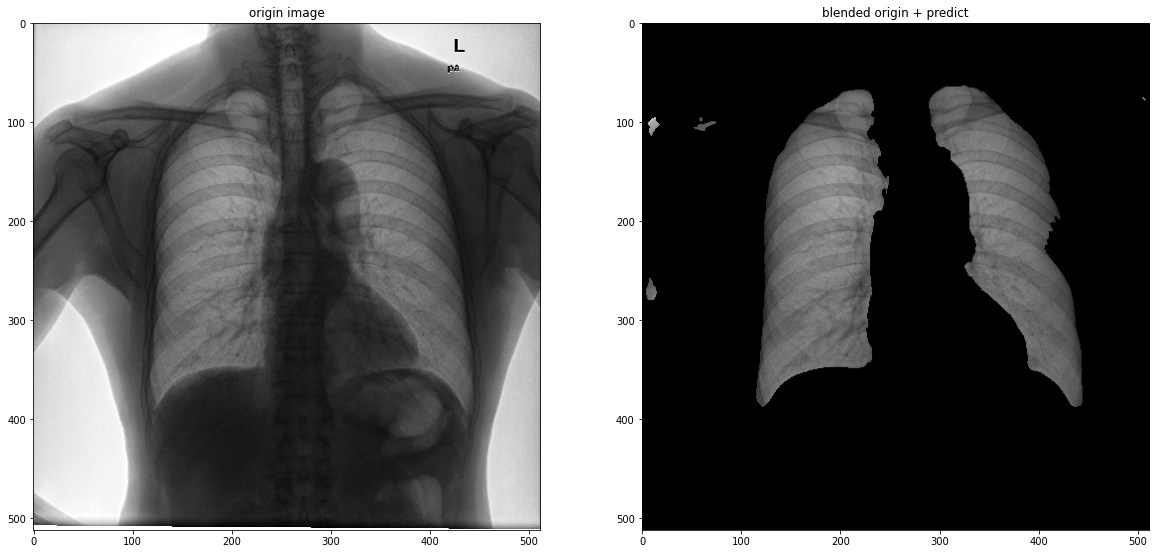

In [103]:
plt.figure(figsize=(20, 10))

pil_origin = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")

plt.subplot(1, 2, 1)
plt.title("origin image")
plt.imshow(np.array(pil_origin))

plt.subplot(1, 2, 2)
plt.title("blended origin + predict")
plt.imshow(np.array(blend(origin, out)));